In [35]:
import torch 
import os 
from functions_data import load_data_and_dictionary, convert_dataframe_to_triples
import functions_ordinal
import numpy as np 
from scipy.stats import entropy
import pandas as pd 
from torch import optim
import matplotlib.pyplot as plt 

data_path = os.path.join(os.getcwd(), 'data', 'three_exams_cleaned.csv')
dict_path = os.path.join(os.getcwd(), 'data', 'questions_info_dict.p')
data, questions_info = load_data_and_dictionary(data_path, dict_path)

n_students, n_questions = data.shape[0], data.shape[1]

# if the score is higher than max score for the given question, put score = max_score 
for col in data:
    m = questions_info[col]['Max']
    data[col].loc[data[col] > m] = m

# rename keys in the questions_info 
new_dictionary, columns_mapper = {}, {}
dict_keys = questions_info.keys()
for ind, key_old in enumerate(dict_keys):
    key_new = 'q' + str(ind + 1)
    new_dictionary[key_new] = questions_info[key_old]
    columns_mapper[key_old] = key_new 

# rename column in the dataframe
data = data.rename(columns=columns_mapper)
max_score = int(data.values.max())


# separate training and pooling students 
training_students = 13563
pooling_students = data.shape[0] - training_students
training_dataframe = data[:training_students]
pooling_dataframe = data[training_students:]


# in the pooling dataframe separate learning and testing data frame
def shuffle_data(raw_data, shuffle_seed=1000):
    df = raw_data.sample(frac=1, axis=1, random_state=np.random.RandomState(shuffle_seed))
    return df
shuffled_pooling_dataframe = shuffle_data(pooling_dataframe)
questions = list(shuffled_pooling_dataframe.columns)
learning_questions = questions[:50]
testing_questions = questions[50:]
learning_pool_df = shuffled_pooling_dataframe[learning_questions]
testing_pool_df = shuffled_pooling_dataframe[testing_questions]
learning_pool = convert_dataframe_to_triples(learning_pool_df)
testing_pool = convert_dataframe_to_triples(testing_pool_df)


#load pretrained parameters 
bs_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', 'bs_pretrained.pth'))
bq0_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', 'bq0_pretrained.pth'))
rho_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', 'rho_pretrained.pth'))


# ACTIVE LEARNING 
s_lp = learning_pool_df.shape[0] # number of students in the learning pool
q_lp = learning_pool_df.shape[1] # number of questions in the learning pool 

torch.manual_seed(1000)
bs_pool = torch.randn(s_lp, requires_grad=True)
bq0_pool = bq0_pretrained
rho_pool = rho_pretrained

active_learning_iterations = q_lp # in every iteration a single question to each student is revealed 

# predictions on the testing pool before the training 
testing_pool_max_scores = functions_ordinal.generate_max_scores_tensor(testing_pool, new_dictionary)
learning_pool_max_scores = functions_ordinal.generate_max_scores_tensor(learning_pool, new_dictionary)

prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
predicted_scores = prob_matrix.argmax(axis = 1)
true_scores = testing_pool[:, 2]

initial_accuracy = functions_ordinal.full_accuracy(true_scores, predicted_scores)
print(f'Accuracy on the testing pool before the training is {initial_accuracy}')

Accuracy on the testing pool before the training is 0.5689747333526611


In [36]:
# functions for revealing the data for training 

def entropy_reveal_one_question_per_student(params, labelled, unlabelled):
    bs_pool, bq0_pool, rho_pool = params[0], params[1], params[2]
    labelled_pool, labelled_max_scores = labelled[0], labelled[1]
    unlabelled_pool, unlabelled_max_scores = unlabelled[0], unlabelled[1]
    
    prob_matrix = functions_ordinal.generate_prob_matrix(unlabelled_pool, bs_pool, bq0_pool, rho_pool, max_score, unlabelled_max_scores).detach()
    prob_matrix_entropy = entropy(prob_matrix, axis=1)
    df = pd.DataFrame(unlabelled_pool.numpy(), columns = ['studentID', 'questionID', 'score'])
    df['entropy'] = prob_matrix_entropy
    df['max_scores'] = unlabelled_max_scores.numpy()
    idx = df.groupby(['studentID'])['entropy'].transform(max) == df['entropy']
    df['max'] = idx 

    # handle the data that remains in the learning pool as unlabeled data 
    unlabelled_pool = df.loc[df['max'] == False][['studentID', 'questionID', 'score']]
    unlabelled_pool = torch.tensor(unlabelled_pool.values)

    unlabelled_max_scores = df.loc[df['max'] == False][['max_scores']]
    unlabelled_max_scores = torch.tensor(unlabelled_max_scores.values.squeeze(1))

    # handle the data that is being revealed to the training and becomes labeled data 
    addition_labelled_pool = df.loc[df['max'] == True][['studentID', 'questionID', 'score']]
    addition_labelled_pool = torch.tensor(addition_labelled_pool.values)

    addition_labelled_max_scores = df.loc[df['max'] == True][['max_scores']]
    addition_labelled_max_scores = torch.tensor(addition_labelled_max_scores.values)
    # append newly labelled data to the pool 
    labelled_pool = torch.cat((labelled_pool, addition_labelled_pool))
    labelled_max_scores = torch.cat((labelled_max_scores, addition_labelled_max_scores.squeeze(1)))

    # pack them back together 
    labelled = [labelled_pool, labelled_max_scores]
    unlabelled = [unlabelled_pool, unlabelled_max_scores]
    
    return labelled, unlabelled

def random_reveal_questions_per_student(labelled, unlabelled, questions_per_student, random_seed):
    labelled_pool, labelled_max_scores = labelled[0], labelled[1]
    unlabelled_pool, unlabelled_max_scores = unlabelled[0], unlabelled[1]

    df = pd.DataFrame(unlabelled_pool.numpy(), columns = ['studentID', 'questionID', 'score'])
    df['max_scores'] = unlabelled_max_scores.numpy()
    df = pd.DataFrame(unlabelled_pool.numpy(), columns = ['studentID', 'questionID', 'score'])
    df['max_scores'] = unlabelled_max_scores.numpy()
    indices = df.groupby('studentID').sample(n=questions_per_student, random_state=random_seed).index.values

    to_label = df.index.isin(indices)

    addition_labelled = df[to_label]
    addition_labelled_pool = torch.tensor(addition_labelled[['studentID', 'questionID', 'score']].values)
    addition_labelled_max_scores = torch.tensor(addition_labelled[['max_scores']].values)
    labelled_pool = torch.cat((labelled_pool, addition_labelled_pool))
    labelled_max_scores = torch.cat((labelled_max_scores, addition_labelled_max_scores.squeeze(1)))


    unlabelled = df[~to_label]
    unlabelled_pool = torch.tensor(unlabelled[['studentID', 'questionID', 'score']].values)
    unlabelled_max_scores = torch.tensor(unlabelled[['max_scores']].values)

    # pack them back together 
    labelled = [labelled_pool, labelled_max_scores]
    unlabelled = [unlabelled_pool, unlabelled_max_scores]
    
    return labelled, unlabelled


def retrain_parameters(labelled_data, labelled_data_max_scores, params, max_score, loss_, it):
    # I think it was not enough training done with 100 iterations later down the line - use more iterations for all 1000 eg. but this number is very prone to experiments 
    # if it < 10:
    #     iterations = 1000 
    # else: 
    #     iterations = 400
    iterations = 200
    opt = optim.SGD(params, lr = 0.0001)
    
    for iter in range(iterations):
        loss = functions_ordinal.nll(labelled_data, params, max_score, labelled_data_max_scores)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_.append(loss/labelled_data.shape[0])
    
    return params, loss_



## Entropy pooling 

In [39]:
#load pretrained parameters 
bs_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', 'bs_pretrained.pth'))
bq0_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', 'bq0_pretrained.pth'))
rho_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', 'rho_pretrained.pth'))

torch.manual_seed(1000)
bs_pool = torch.randn(s_lp, requires_grad=True)
bq0_pool = bq0_pretrained
rho_pool = rho_pretrained

# pre-requisites for AL 

s_lp = learning_pool_df.shape[0] # number of students in the learning pool
q_lp = learning_pool_df.shape[1] # number of questions in the learning pool 

# separate labelled and unlabelled data; for beginning labelled data is none data and unlabelled data is all data in the learning pool 
labelled_pool = torch.tensor([])
unlabelled_pool = learning_pool.clone()

labelled_max_scores = torch.tensor([])
unlabelled_max_scores = learning_pool_max_scores.clone()

prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
predicted_scores = prob_matrix.argmax(axis = 1)
true_scores = testing_pool[:, 2]

initial_accuracy = functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy()
print(f'Initial accuracy on the testing pool is {initial_accuracy}')

Initial accuracy on the testing pool is 0.5689747333526611


In [40]:
# Entropy based active learning training 
loss_ = []
accs_entropy = [initial_accuracy]

random_Seed = 1000 
questions_per_student = 2
iterations = int(q_lp / questions_per_student) # number of retraining iterations based on how many questions are revealed to each student in every iteration
params = [bs_pool, bq0_pool, rho_pool]
labelled = [labelled_pool, labelled_max_scores]
unlabelled = [unlabelled_pool, unlabelled_max_scores]

print(f'I will be training now for {iterations} iterations')

for it in range(iterations):
    labelled, unlabelled = entropy_reveal_one_question_per_student(params, labelled, unlabelled)
    labelled, unlabelled = entropy_reveal_one_question_per_student(params, labelled, unlabelled)
    labelled_data, labelled_data_max_scores = labelled[0], labelled[1]

    params, loss_ = retrain_parameters(labelled_data, labelled_data_max_scores, params, max_score, loss_, it)

    prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
    predicted_scores, true_scores = prob_matrix.argmax(axis = 1), testing_pool[:, 2]
    accs_entropy.append(functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy())
    
    if it % 10 == 0:
        print(it)

I will be training now for 25 iterations
0
10
20


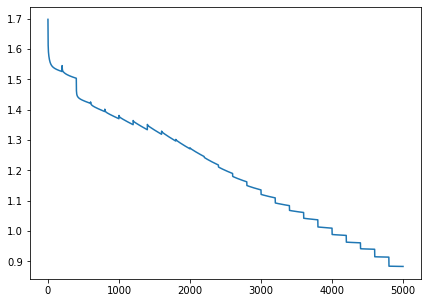

In [41]:
loss_entropy = []
for l in loss_:
    loss_entropy.append(l.detach().numpy())
plt.plot(loss_entropy)

In [42]:
bs_entropy = bs_pool.clone()
bq0_entropy = bq0_pool.clone()
rho_entropy = rho_pool.clone()

##  Random pooling 

In [43]:
#load pretrained parameters 
bs_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', 'bs_pretrained.pth'))
bq0_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', 'bq0_pretrained.pth'))
rho_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', 'rho_pretrained.pth'))

torch.manual_seed(1000)
bs_pool = torch.randn(s_lp, requires_grad=True)
bq0_pool = bq0_pretrained
rho_pool = rho_pretrained

# pre-requisites for AL 

s_lp = learning_pool_df.shape[0] # number of students in the learning pool
q_lp = learning_pool_df.shape[1] # number of questions in the learning pool 

# separate labelled and unlabelled data; for beginning labelled data is none data and unlabelled data is all data in the learning pool 
labelled_pool = torch.tensor([])
unlabelled_pool = learning_pool.clone()

labelled_max_scores = torch.tensor([])
unlabelled_max_scores = learning_pool_max_scores.clone()

prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
predicted_scores = prob_matrix.argmax(axis = 1)
true_scores = testing_pool[:, 2]

initial_accuracy = functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy()
print(f'Initial accuracy on the testing pool is {initial_accuracy}')

Initial accuracy on the testing pool is 0.5689747333526611


In [44]:
# Random selection of a question per student revealed 
loss_random = []
accs_random = [initial_accuracy]

random_seed = 1000 
questions_per_student = 2
iterations = int(q_lp / questions_per_student) # number of retraining iterations based on how many questions are revealed to each student in every iteration
params = [bs_pool, bq0_pool, rho_pool]
labelled = [labelled_pool, labelled_max_scores]
unlabelled = [unlabelled_pool, unlabelled_max_scores]

print(f'I will be training now for {iterations}')

for it in range(iterations):
    labelled, unlabelled = random_reveal_questions_per_student(labelled, unlabelled, questions_per_student, random_seed)
    labelled_data, labelled_data_max_scores = labelled[0], labelled[1]

    params, loss_random = retrain_parameters(labelled_data, labelled_data_max_scores, params, max_score, loss_random, it)

    prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
    predicted_scores, true_scores = prob_matrix.argmax(axis = 1), testing_pool[:, 2]
    accs_random.append(functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy())
    
    if it % 10 == 0:
        print(it)

I will be training now for 25
0
10
20


In [45]:
bs_random = bs_pool.clone()
bq0_random = bq0_pool.clone()
rho_random = rho_pool.clone()

In [46]:
loss_r = []
for l in loss_random:
    loss_r.append(l.detach().numpy())

## Plotting for entropy and random pooling 

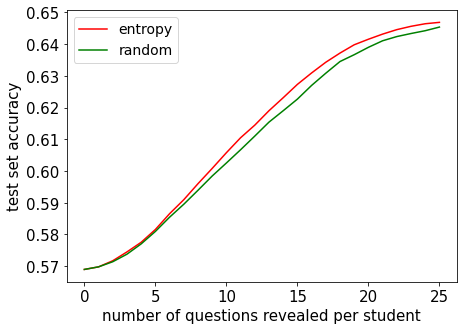

In [47]:
# Random question selection training 
plt.rcParams["figure.figsize"] = (7,5)
plt.plot(accs_entropy, label = 'entropy', color = 'r')
plt.plot(accs_random, label='random', color = 'g')
plt.legend(fontsize = 14)
plt.xlabel('number of questions revealed per student', fontsize = 15)
plt.ylabel('test set accuracy', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

torch.save(accs_random, os.path.join(os.getcwd(), 'al_params', 'accs_random_200.pth'))
torch.save(accs_entropy, os.path.join(os.getcwd(), 'al_params', 'accs_entropy_200.pth'))

In [14]:
rdn = torch.load(os.path.join(os.getcwd(), 'al_params', 'accs_random_1000_400.pth'))
entr = torch.load(os.path.join(os.getcwd(), 'al_params', 'accs_entropy_1000_400.pth'))

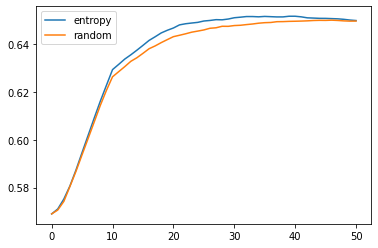

In [15]:
# Random question selection training 
plt.plot(entr, label = 'entropy')
plt.plot(rdn, label='random')
plt.legend()
plt.show()

In [ ]:
# Random question selection training 
plt.plot(loss_entropy, label = 'entropy')
plt.plot(loss_r, label='random')
plt.legend()
plt.show()